In [2]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 100
rcParams["savefig.dpi"] = 150

import numpy as np
#import corner
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
from maelstrom import Maelstrom

red = '#e41a1c'
blue = '#377eb8'
green = '#4daf4a'
purple = '#984ea3'
orange = '#ff7f00'

ModuleNotFoundError: No module named 'maelstrom'

In [ ]:
import matplotlib
matplotlib.rcParams["font.size"] = 9.

def mnras_size(fig_width_pt, square=False):
    #Paper width = 597.5  for 2 columns or 504?
    #Col width = 240.0    #for single column
    inches_per_pt = 1.0/72.00              # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0         # Most aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt  # Figure width in inches
    if square:
        fig_height = fig_width
    else:
        fig_height = fig_width*golden_mean
    fig_size = [fig_width,fig_height]
    return fig_size

In [3]:
from exoplanet.utils import eval_in_model
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt

class SyntheticBinary(object):
    """
    This class makes a synthetic light curve and injects a time delay signal corresponding to the input binary orbit parameters    
    """
    def __init__(self, time, freq, amplitude, 
                 period, eccen, asini, varpi, tref):
        self.time = time
        self.freq = freq
        self.amplitude = amplitude
        self.period, self.eccen, self.asini, self.varpi, self.tref = period, eccen, asini, varpi, tref
        
        self.make_lightcurve()
        self.flux = self.flux_true
        
    def make_lightcurve(self):
        self.flux_true = np.zeros(len(self.time))
        
        with pm.Model() as model:
            #M = tt.zeros_like(tt.constant(self.time) - self.tref) + 2.0 * np.pi * (tt.constant(self.time)) / self.period
            M = 2.0 * np.pi * (tt.constant(self.time) - self.tref) / self.period
            f = get_true_anomaly(M, self.eccen + tt.zeros_like(M))
            tau_tens = (- (1 - tt.square(self.eccen)) * tt.sin(f+self.varpi) / (1 + self.eccen*tt.cos(f))) * (self.asini / 86400.)
            self.tau = eval_in_model(tau_tens)
            
        for j, A_j in zip(self.freq, self.amplitude):
            omega = 2 * np.pi * j
            self.flux_true += A_j * np.cos(omega * (self.time - self.tau)) + A_j * np.sin(omega * (self.time - self.tau))
            
    def add_noise(self, noise=0.05):
        # Add noise
        np.random.seed(42)
        self.flux_err = noise * np.std(self.flux_true)
        self.flux = self.flux_true + self.flux_err * np.random.randn(len(self.flux_true))
        
    @staticmethod
    def quick_star(self, star='dsct', mission='kepler'):
        """
        Don't use me. yet.
        """
        if star == 'dsct':
            pass

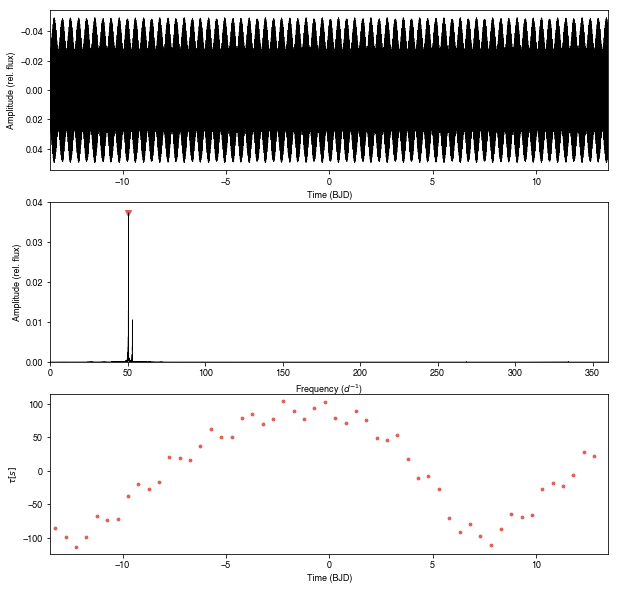

In [4]:
# Check time delay signal is injected properly
period = 20.
eccen = 0.5
asini = 100
varpi = 1.
tref = 0.

n_freq = 2
freqs = np.random.normal(loc=50., scale=2., size=n_freq)
amps = np.random.normal(loc=0.01, scale=0.01, size=n_freq)

# TESS 2 min cadence for 1 sector
time = np.arange(0, 27, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs, amps,
                     period, eccen, asini, varpi, tref)
#lc.add_noise(noise=4.)

ms = Maelstrom(lc.time, lc.flux, max_peaks=1)
ms.first_look(segment_size=0.5)

In [5]:
from astropy.stats import LombScargle
from astropy.convolution import convolve, Box1DKernel
import math

def amp_spectrum(t, y, fmin=None, fmax=None, nyq_mult=1., oversample_factor=5.):
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)
    
    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = (0.5 / np.median(np.diff(t)))*nyq_mult

    freq = np.arange(fmin, fmax, df / oversample_factor)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4./len(t))
    amp = np.sqrt(sc) * fct
    
    return freq, amp


def smooth(freq, power, method='boxkernel', filter_width=0.1):

    if method == 'boxkernel':
        if filter_width <= 0.:
            raise ValueError("the `filter_width` parameter must be "
                             "larger than 0 for the 'boxkernel' method.")
        fs = np.mean(np.diff(freq))
        box_kernel = Box1DKernel(math.ceil((filter_width/fs)))
        smooth_power = convolve(power, box_kernel)
        return smooth_power

    if method == 'logmedian':
        count = np.zeros(len(freq), dtype=int)
        bkg = np.zeros_like(freq)
        x0 = np.log10(freq[0])
        while x0 < np.log10(freq[-1]):
            m = np.abs(np.log10(freq) - x0) < filter_width
            if len(bkg[m] > 0):
                bkg[m] += np.nanmedian(power)
                count[m] += 1
            x0 += 0.5 * filter_width
        bkg /= count
        smooth_power = bkg
        return smooth_power

In [8]:
import tqdm

amps = [0.001]
nu_arr = np.array([50])
noises = np.geomspace(0.1,10,20)
#noises = [2,5,100]
time_t = np.arange(0, 27, 1.0 / (24 * 30))


In [37]:

snr, std_hess = [], []
period_t = 10.
eccen_t = 0.5
asini_t = 100
varpi_t = 1.
tref_t = 0.
#noises = [noises[0]]
for noise in tqdm.tqdm(noises):
    time_t = np.arange(0, 27, 1.0 / (24 * 30))
    
    lc = SyntheticBinary(time_t, nu_arr,amps,
                         period_t, eccen_t, asini_t, varpi_t, tref_t)
    lc.add_noise(noise=noise)
    # Calculate SNR
    freq, amp = amp_spectrum(lc.time, lc.flux, fmin=45., fmax=55.)
    smoothed = smooth(freq, amp, filter_width=0.01, method='logmedian')
    val = amp / smoothed
    snr.append(np.max(val))
    
    t = lc.time
    y = lc.flux
    ms = Maelstrom(t,y, freq=nu_arr)
    td_time, td_td = ms.get_time_delay(segment_size=1.)
    td_td = np.average(td_td, axis=0)
    td_time = np.array(td_time + ms.time_mid)

    with pm.Model() as model:
        # Parameters
        #period = pm.Normal("period", mu=1000., sd=.)
        period = pm.Normal("period", mu=period_t, sd=5.)
        #period = pm.Uniform('period', lower=1., upper=15., testval=10.)
        tref = 0.#pm.Normal("tref", mu=0., sd=5.)
        varpi = 1.#pm.Normal("varpi", mu=1., sd=5.)
        eccen = 0.5#pm.Uniform("eccen", lower=1e-3, upper=0.999, testval=0.5)
        #logs = pm.Normal('logs', mu=np.log(np.std(y)), sd=10)
        #jitter = pm.Uniform('jitter', lower=0, upper=10)
        lighttime = pm.Normal('lighttime', mu=asini_t, sd=5.)
        #lighttime = pm.Uniform('lighttime', lower=50, upper=150, testval=100.)

        # Deterministic transformations
        # Mean anom
        M = 2.0 * np.pi * (tt.constant(td_time) - tref) / period
        # True anom
        f = get_true_anomaly(M, eccen + tt.zeros_like(M))

        factor = 1.0 - tt.square(eccen)
        factor /= 1.0 + eccen * tt.cos(f)
        psi = -factor * tt.sin(f + varpi)

        tau = lighttime * psi
        taumodel = tau - tt.mean(tau)

        # Condition on the observations
        pm.Normal("obs_photometry", mu=taumodel, sd=1., observed=td_td)
    
        #map_soln = pm.find_MAP(progressbar=False)
        map_soln = {
            'period': np.array(10.),
            'lighttime': np.array(100.),
        }
        
        hess = pm.find_hessian(map_soln, model=model)
        std_hess.append(np.diagonal((1/np.abs(hess))**0.5)[0])

100%|██████████| 50/50 [08:26<00:00, 10.37s/it]


In [9]:
time_t = np.arange(0, 27, 1.0 / (24 * 30))

snr_mael = []
hess_mael = []
hess_mael_inv = []

period_t = 10.
eccen_t = 0.5
asini_t = 100
varpi_t = 1.
tref_t = 0.
#noises = [noises[0]]
for noise in tqdm.tqdm(noises):
    lc = SyntheticBinary(time_t, nu_arr,amps,
                         period_t, eccen_t, asini_t, varpi_t, tref_t)
    lc.add_noise(noise=noise)
    # Calculate SNR
    freq, amp = amp_spectrum(lc.time, lc.flux, fmin=45., fmax=55.)
    smoothed = smooth(freq, amp, filter_width=0.01, method='logmedian')
    val = amp / smoothed
    snr_mael.append(np.max(val))
    
    t = lc.time
    y = lc.flux

    with pm.Model() as model:
        # Parameters
        period = pm.Normal("period", mu=period_t, sd=5.)
        tref = tref_t#pm.Uniform("tref", lower=-50000, upper=50000)
        varpi = 1.#pm.Uniform("varpi", lower=1e-2, upper=10)
        eccen = eccen_t#pm.Uniform("eccen", lower=1e-11, upper=0.99)
        #jitter = pm.Uniform('jitter', lower=0, upper=10)
        lighttime = asini_t#pm.Normal('lighttime', mu=asini_t, sd=1.)

        # Mean anom
        M = 2.0 * np.pi * (tt.constant(t) - tref) / period
        # True anom
        f = get_true_anomaly(M, eccen + tt.zeros_like(M))

        psi = - (1 - tt.square(eccen)) * tt.sin(f+varpi) / (1 + eccen*tt.cos(f))

        # tau in d
        tau = (lighttime) * psi[:,None]
        tau /= 86400.

        arg = 2. * np.pi * nu_arr[None, :] * (t[:,None] - tau)
        D = tt.concatenate([tt.cos(arg), tt.sin(arg)],axis=1)
        DTD = tt.dot(D.T,D)
        DTy = tt.dot(D.T, y[:, None])
        W_hat = tt.slinalg.solve(DTD, DTy)

        model_tensor = tt.squeeze(tt.dot(D,W_hat))

        # Sue me again
        model_tensor = model_tensor

        # Condition on the observations
        pm.Normal("obs", mu=model_tensor, sd=None, observed=y)

        #map_soln = pm.find_MAP()
        map_soln = {
            'period': np.array(period_t)
        }
        hess = pm.find_hessian(map_soln, model=model)
        hess_mael.append(np.diagonal((1/np.abs(hess))**0.5)[0])
        hess_mael_inv.append(np.sqrt(np.diag(np.linalg.inv(hess))))

100%|██████████| 20/20 [02:28<00:00,  6.88s/it]


In [39]:
normed_mael = (hess_mael-min(hess_mael))/(max(hess_mael)-min(hess_mael))
normed_hess = (std_hess-min(std_hess))/(max(std_hess)-min(std_hess))

ValueError: x and y must have same first dimension, but have shapes (0,) and (50,)

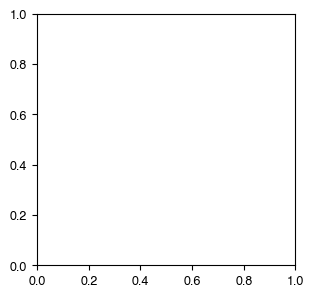

In [51]:
hess_mael = np.array(hess_mael)
fig, ax = plt.subplots(figsize=mnras_size(240., square=True))
ax.plot(snr_mael, normed_mael, '-', c=blue, label='Maelstrom', linewidth=1)
ax.plot(snr, normed_hess, '-', c=red, label='Segmented model', linewidth=1)
ax.set_xlabel('SNR')
ax.set_ylabel(r'Normalised $\sigma_{\rm Period}$')
plt.legend()

one_e = 0.36787944117144233
ax.hlines(one_e, xmin=0, xmax=35.5, linestyles='dashed', linewidth=0.7)
ax.vlines(24.5, ymin=0, ymax=one_e, linestyles='dashed', linewidth=0.7)
ax.vlines(35.5, ymin=0, ymax=one_e, linestyles='dashed', linewidth=0.7)
#plt.axhline(0.36787944117144233, xmin=0, xmax=0.08)
#plt.savefig('interesting.png', dpi=300)
ax.set_xlim(0,100)
ax.set_ylim(0,1.)
#plt.savefig('/Users/danielhey/Dropbox (Sydney Uni)/Apps/Overleaf/Maelstrom/figs/period_uncertainty.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [50]:
100 * freqs

array([  100.        ,   621.05263158,  1142.10526316,  1663.15789474,
        2184.21052632,  2705.26315789,  3226.31578947,  3747.36842105,
        4268.42105263,  4789.47368421,  5310.52631579,  5831.57894737,
        6352.63157895,  6873.68421053,  7394.73684211,  7915.78947368,
        8436.84210526,  8957.89473684,  9478.94736842, 10000.        ])

In [47]:
time_t = np.arange(0, 27, 1.0 / (24 * 30))

freqs = np.linspace(1,100,20)
snr_mael = []
hess_mael = []

period_t = 10.
eccen_t = 0.5
asini_t = 100
varpi_t = 1.
tref_t = 0.
#noises = [noises[0]]
for freq in tqdm.tqdm(freqs):
    nu_arr = np.array([freq])
    lc = SyntheticBinary(time_t, nu_arr,amps,
                         period_t, eccen_t, asini_t, varpi_t, tref_t)
    lc.add_noise(noise=noise)
    
    t = lc.time
    y = lc.flux

    with pm.Model() as model:
        # Parameters
        period = pm.Normal("period", mu=period_t, sd=1.)
        tref = tref_t#pm.Uniform("tref", lower=-50000, upper=50000)
        varpi = 1.#pm.Uniform("varpi", lower=1e-2, upper=10)
        eccen = eccen_t#pm.Uniform("eccen", lower=1e-11, upper=0.99)
        #jitter = pm.Uniform('jitter', lower=0, upper=10)
        lighttime = asini_t#pm.Normal('lighttime', mu=asini_t, sd=1.)

        # Mean anom
        M = 2.0 * np.pi * (tt.constant(t) - tref) / period
        # True anom
        f = get_true_anomaly(M, eccen + tt.zeros_like(M))

        psi = - (1 - tt.square(eccen)) * tt.sin(f+varpi) / (1 + eccen*tt.cos(f))

        # tau in d
        tau = (lighttime) * psi[:,None]
        tau /= 86400.

        arg = 2. * np.pi * nu_arr[None, :] * (t[:,None] - tau)
        D = tt.concatenate([tt.cos(arg), tt.sin(arg)],axis=1)
        DTD = tt.dot(D.T,D)
        DTy = tt.dot(D.T, y[:, None])
        W_hat = tt.slinalg.solve(DTD, DTy)

        model_tensor = tt.squeeze(tt.dot(D,W_hat))

        # Sue me again
        model_tensor = model_tensor

        # Condition on the observations
        pm.Normal("obs", mu=model_tensor, sd=None, observed=y)

        #map_soln = pm.find_MAP()
        map_soln = {
            'period': np.array(period_t)
        }
        hess = pm.find_hessian(map_soln, model=model)
        hess_mael.append(np.diagonal((1/np.abs(hess))**0.5)[0])

100%|██████████| 20/20 [03:23<00:00, 10.49s/it]


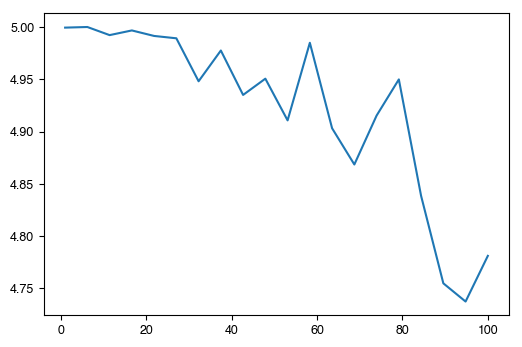

In [48]:
plt.plot(freqs, hess_mael)